## `MATLAB` Example
To see the need for registration in context, consider reading the following two images into `MATLAB`

In [5]:
anat = spm_data_read('sub-01_T1w.nii');
func = spm_data_read('sub-01_task-flanker_run-1_bold.nii,1');

You can downloaded the [anatomical image]() and the [functional image]() yourself, if you want to follow along.

Now, consider an example situation where we are interested in voxel $[87,182,127]$ from the anatomical image. For instance, we may have already identified this as part of the anterior cingulate which is of interest in this study. We can extract the measured value from the anatomical image easily

In [7]:
anat(87,182,127)

ans = 210

However, for the functional file we hit a problem

In [9]:
func(87,182,127)

Index in position 1 exceeds array bounds. Index must not exceed 64.

This is because the functional data is much *smaller* than the anatomical data, which we can see by querying the dimensions in `MATLAB`

In [11]:
size(anat)
size(func)

ans = 1x3 double
   176   256   256

ans = 1x3 double
    64    64    40

Clearly, the functional image needs scaling in order to match the dimensions of the anatomical image. This requires some form of *interpolation*, which we can achieve using the `spm_reslice()` function. You will not need to call this from code usually, but you can see how to do it below.

In [13]:
files = {'sub-01_T1w.nii','sub-01_task-flanker_run-1_bold.nii,1'};
flags = spm_get_defaults('realign.write');
flags.which  = 1; % Just resample the functional image
flags.interp = 0; % Nearest-neighbour
spm_reslice(files,flags);

Defaults settings have been modified by file(s):
  C:\Users\marty\Documents\MATLAB\spm_my_defaults.m
Modified fields: ui stats 

SPM12: spm_reslice (v7141)                         14:34:57 - 17/10/2024
Completed                               :          14:34:59 - 17/10/2024


A new file called `rsub-01_task-flanker_run-1_bold.nii` will now be saved, containing the functional data resampled into the space of the anatomical data. If we now read in the interpolated functional data, we can see that both images are now the same size.

In [15]:
ifunc = spm_data_read('rsub-01_task-flanker_run-1_bold.nii,1');
size(anat)
size(ifunc)

ans = 1x3 double
   176   256   256

ans = 1x3 double
   176   256   256

Which means we can now extract the matching data from the functional image

In [17]:
ifunc(87,182,127)

ans = 6

This would seem to be a job well done. However, just because we have managed to create a mapping between these two images (by resampling the functional to the same dimensions as the anatomical) does not immediately mean that the same locations will align. We can see this if we overlay the two images

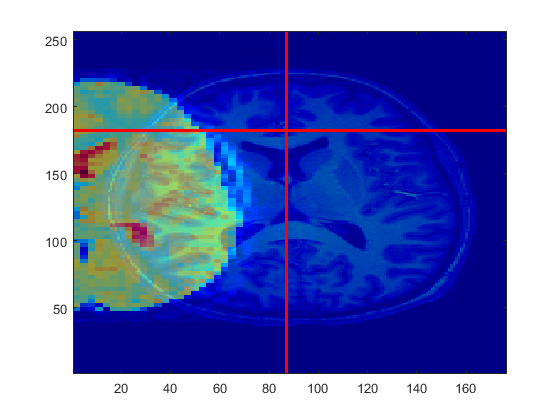

In [42]:
figure;
imagesc(anat(:,:,127)');
hold on; 
imagesc(ifunc(:,:,127)','AlphaData',0.6); % draw func transparent
set(gca,'YDir','normal');
colormap jet;
drawcrosshair('Position',[87 182],'Color','r');

So even though we solved the initial problem of different image dimensions, because the images are not registered, simply resampling one image into the space of the other does not automatically cause the anatomy to align. The result for this example is that voxel $[87,182,127]$ corresponds to the anterior cingulate in the anatomical image, but is actually *outside the brain* in the functional image. As such, even though the location $[87,182,127]$ now exists in *both* images, it does not represent the same anatomical structure. 

Understanding why the anatomy does not line-up after resampling, as well as how to fix this, is the focus of the rest of this lesson.